# Data Analysis on Facebook posts

*This notebook is view-only for now, since MongoDB GCE restricted access for certain IP address, this notebook is built locally with the Mongodb server tunneling to localhost as well. To run this, we can host jupyter server on any VM that is accessible to the Mongo server.*

Data from MongoDB production-mongo-1, we mainly look at post_summary collection in facebook database. We look at all the posts from 2017-05-01 to 2017-05-31 for shared page only. post_summary stop getting updates after 2 weeks so data is static.



Some key findings so far, based on some generalization and assumptions:
1. We post about 45 posts everyday, 84% of them are link post, 14% are video posts, 3% are photo posts.
2. On average, they should see about 84 posts on their news feed average per month (about 127 impressions).
3. they make about 5 clicks each month.


---
- How much a facebook page fan worth?
- How much a link click worth?
- breakdown by post type
- breakdown by brand
- Fan vs non-fan
- How much on average a page fan worth?
- How many times on average a page fan like our posts (or view content)?
- How much on average a like on our post worth?
- How much on average a share on our post worth? (reach)
- Link clicks vs likes ratio of all posts
- Estimate the probability a fan/non-fan click on a post
- Estimate link click by likes/share/comments (break down by post_type)


---


In [10]:
%matplotlib inline
import pymongo
import json
from pprint import pprint
from pymongo import MongoClient
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
from scipy import stats
from bson.code import Code
matplotlib.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

client = MongoClient()
client = MongoClient('mongodb://localhost:27017') #tunnelling to localhost

#what databases are available
#pprint(client.database_names())
# facebook database
db = client.facebook
#what collections are available
#pprint(db.collection_names())
collection = db.post_summary

startdate = '2017-05-01'
enddate = '2017-05-31'

## Overview

Up to 2016-12-16, there are 301,368 posts in the collection, 19,837 of them are posted on Shared Facebook page, in 2016 Nov, there are 1397 posts.

In [11]:
pprint(collection.count())
pprint(collection.find({'page_name':'Shared'}).count())
pprint(collection.find({'page_name':'Shared','date':{'$gte': startdate,'$lte': enddate}}).count())

384499
29841
1850


Let's have a look on one record, fields that are useful:
- page_name (filter by 'Shared')
- date (filter from 2017-05-01 to 2017-05-31')
- post_id 
- post_type (link, photo, video)
- brand_domain (breakdown by brand)
- page_likes (Shared page fan on the day the post created)
- post_likes (post_likes_on_post, post_likes_on_shares)
- post_comments (post_comments_on_post, post_comments_on_shares)
- post_shares
- post_reactions_total (like, love, wow, haha, sad, angry, thankful)
- post_impressions_unique (The number of people who saw your Page post)
- post_impressions (The number of impressions for your Page post)
- post_impressions_fan (The number of impressions for your Page post by people who have liked your Page)
- post_impressions_fan_unique (The number of people who have like your Page who saw your Page post)
- post_link_clicks (The number of clicks on the link)
- **post_link_clicks_unique** (The number of people who have click on the link, this is our conversion)
- post_engaged_users (The number of people who clicked anywhere in your posts)
- timestamp (post created timestamp)
- updated_at (post last update timestamp, usually it is 2 week after the created timestamp)
- reached_size_ratio (post_impressions_unique / page_likes)
- reached_size_ratio_fan (post_impressions_fan_unique / page_likes)
- click_size_ratio (post_link_clicks / page_size)
- clicks_to_impressions (post_clicks / post_impressions_unique)
- link_clicks_to_impressions (post_link_clicks / post_impressions_unique)



In [15]:
collection.find_one({'page_name':'Shared','date':{'$gte': startdate,'$lte': enddate}});

 **We post around 50-70 posts a day on Shared page, average is 62 posts.**

min:  49
max:  68
avg:  61.6666666667


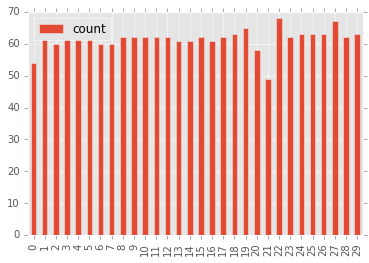

In [12]:
post_count_by_day = \
    sorted(list(collection.aggregate([{'$match': {'page_name': 'Shared'
           , 'date':{'$gte': startdate,'$lte': enddate}}},
           {'$group': {'_id': '$date', 'count': {'$sum': 1}}}])),
           key=lambda k: k['_id'])
post_count_by_day_df = json_normalize(post_count_by_day)
post_count_by_day_df[['_id','count']].plot.bar()
print 'min: ',np.min(post_count_by_day_df['count'])
print 'max: ',np.max(post_count_by_day_df['count'])
print 'avg: ',np.average(post_count_by_day_df['count'])

In [23]:
reducer = \
    Code("""
    function(obj, prev) {
        if (true != null) if (true instanceof Array) prev.countstar += true.length;
        else prev.countstar++;
        prev.sumpost_likes = prev.sumpost_likes + obj.post_likes - 0;
        prev.sumpost_comments = prev.sumpost_comments + obj.post_comments - 0;
        prev.sumpost_shares = prev.sumpost_shares + obj.post_shares - 0;
        prev.sumpost_reactions_total = prev.sumpost_reactions_total + obj.post_reactions_total - 0;
        prev.sumpost_impressions_unique = prev.sumpost_impressions_unique + obj.post_impressions_unique - 0;
        prev.sumpost_impressions = prev.sumpost_impressions + obj.post_impressions - 0;
        prev.sumpost_impressions_fan = prev.sumpost_impressions_fan + obj.post_impressions_fan - 0;
        prev.sumpost_impressions_fan_unique = prev.sumpost_impressions_fan_unique + obj.post_impressions_fan_unique - 0;
        prev.sumpost_link_clicks = prev.sumpost_link_clicks + obj.post_link_clicks - 0;
        prev.sumpost_link_clicks_unique = prev.sumpost_link_clicks_unique + obj.post_link_clicks_unique - 0;
        prev.sumpost_engaged_users = prev.sumpost_engaged_users + obj.post_engaged_users - 0;
        prev.sumreached_size_ratio = prev.sumreached_size_ratio + obj.reached_size_ratio - 0;
        prev.sumreached_size_ratio_fan = prev.sumreached_size_ratio_fan + obj.reached_size_ratio_fan - 0;
        prev.sumclick_size_ratio = prev.sumclick_size_ratio + obj.click_size_ratio - 0;
        prev.sumclicks_to_impressions = prev.sumclicks_to_impressions + obj.clicks_to_impressions - 0;
        prev.sumlink_clicks_to_impressions = prev.sumlink_clicks_to_impressions + obj.link_clicks_to_impressions - 0;
    }
    """)

post_summary_sum = db.post_summary.group(key=None,initial={
    'countstar': 0,
    'sumpost_engaged_users': 0,
    'sumpost_reactions_total': 0,
    'sumpost_link_clicks': 0,
    'sumpost_impressions_unique': 0,
    'sumpost_likes': 0,
    'sumpost_comments': 0,
    'sumpost_shares': 0,
    'sumpost_impressions': 0,
    'sumpost_impressions_fan': 0,
    'sumpost_impressions_fan_unique': 0,
    'sumpost_link_clicks_unique': 0,
    'sumreached_size_ratio': 0,
    'sumreached_size_ratio_fan': 0,
    'sumclick_size_ratio': 0,
    'sumclicks_to_impressions': 0,
    'sumlink_clicks_to_impressions': 0,
    }, reduce=reducer, condition={'page_name': 'Shared',
                                  'date': {'$gt': startdate,
                                  '$lt': enddate}}, finalize=None)

post_summary_avg = pd.DataFrame(post_summary_sum).transpose()
post_summary_avg['avg'] = post_summary_avg / post_summary_avg[0]['countstar']
post_summary_avg

,0,avg
countstar,1850.000,1.000
sumclick_size_ratio,622.668,0.337
sumclicks_to_impressions,14372.348,7.769
sumlink_clicks_to_impressions,10078.387,5.448
sumpost_comments,3293198.000,1780.107
sumpost_engaged_users,126862588.000,68574.372
sumpost_impressions,2835899274.000,1532918.526
sumpost_impressions_fan,1607171019.000,868741.091
sumpost_impressions_fan_unique,1059829098.000,572880.594
sumpost_impressions_unique,1789781536.000,967449.479


We have about 1 million (sumpost_impressions) impressions for each post, however, they are  660k (sumpost_impressions_unique) unique people who account for the 1 million impressions, on average, they made about 1.55 impressions for each posts.

Out of the 660k people, 70% of them are our page fan (sumpost_impressions_fan_unique). That is about 6% (sumreached_size_ratio_fan) of our page size, however we don't know if the 6% are overlapped for each post, we will assume that they are randomly selected. We can model it using binomial distribution where p=0.06, we have about 1400 posts a month. The probabilty distribution:

Also, taking average on a post, 446k of fan accounts for 677k of impressions which is about 1.517 impressions for each posts.

5% percentile:  70.0


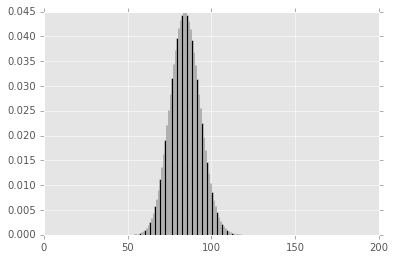

In [13]:
x = range(200)
y = stats.binom.pmf(x,1397,0.06)
plt.bar(x,y, color="black")

print "5% percentile: ",stats.binom.ppf(0.05, 1400, 0.06, loc=0)

**On average, they should see about 84 posts on average per month (about 127 impressions).** 95% of them will see at least 70 posts (~106 impressions).

Next we need P(link click | impression), given an impression, what is the probabilty that one will click on the link? 4%
given an impression, there are 4% chance they click on a link. Lets say on average they see about 127 impressions, **they make about 5 clicks on any of our posts each month.**

Next we need to estimate how much a link click worth, it gets a little bit tricky, first a post could be shared from our webpage post, then we earn money by 


In [21]:
avg_link_clicks_unique_to_impressions_unique = np.average(pd.DataFrame(list(collection.aggregate([{'$match': {'page_name': 'Shared'
           , 'date': {'$gte': '2016-11-01', '$lte': '2016-12-01'}}},
           {'$project': {'avg_link_clicks_unique_to_impression_unique': {'$divide': ['$post_link_clicks_unique'
           , '$post_impressions_unique'
           ]}}}])))['avg_link_clicks_unique_to_impression_unique'])  
# ad-hoc link_clicks_unique_impressions_unique ratio, it is not available on Mongo

avg_link_clicks_to_impressions = np.average(pd.DataFrame(list(collection.aggregate([{'$match': {'page_name': 'Shared'
           , 'date': {'$gte': '2016-11-01', '$lte': '2016-12-01'}}},
           {'$project': {'avg_link_clicks_to_impressions': {'$divide': ['$post_link_clicks'
           , '$post_impressions'
           ]}}}])))['avg_link_clicks_to_impressions'])  

# ad-hoc link_clicks_impressions ratio, it is not available on Mongo

print 'avg_link_clicks_unique_to_impressions_unique: ',avg_link_clicks_unique_to_impressions_unique
print 'avg_link_clicks_to_impressions: ' ,avg_link_clicks_to_impressions

avg_link_clicks_unique_to_impressions_unique:  0.0559491023996
avg_link_clicks_to_impressions:  0.0406127205586


In [43]:
post_summary_sum_all = [
    {
        "countstar" : 14403.0,
        "sumpost_engaged_users" : 240145008.0,
        "sumpost_reactions_total" : 47805256.0,
        "sumpost_link_clicks" : 129899056.0,
        "sumpost_impressions_unique" : 3803353574.0,
        "sumpost_likes" : 19562261.0,
        "sumpost_comments" : 3469426.0,
        "sumpost_shares" : 8383445.0,
        "sumpost_impressions" : 3023139590.0,
        "sumpost_impressions_fan" : 1549535877.0,
        "sumpost_impressions_fan_unique" : 2020556792.0,
        "sumpost_link_clicks_unique" : 59688363.0,
        "sumreached_size_ratio" : 180160.282775814,
        "sumreached_size_ratio_fan" : 69940.7299740468,
        "sumclick_size_ratio" : 4269.89328127687,
        "sumclicks_to_impressions" : 102332.529292097,
        "sumlink_clicks_to_impressions" : 74181.4963846702
    }
]

post_summary_avg_all = pd.DataFrame(post_summary_sum_all).transpose()
post_summary_avg_all['avg'] = post_summary_avg_all / 14403
post_summary_avg_all

,0,avg
countstar,14403.000,1.000
sumclick_size_ratio,4269.893,0.296
sumclicks_to_impressions,102332.529,7.105
sumlink_clicks_to_impressions,74181.496,5.150
sumpost_comments,3469426.000,240.882
sumpost_engaged_users,240145008.000,16673.263
sumpost_impressions,3023139590.000,209896.521
sumpost_impressions_fan,1549535877.000,107584.245
sumpost_impressions_fan_unique,2020556792.000,140287.217
sumpost_impressions_unique,3803353574.000,264066.762


### Breakdown by post type

In [27]:
post_type_count = \
    list(collection.aggregate([{'$match': {'page_name': 'Shared',
         'date': {'$gte': '2016-11-01', '$lte': '2016-12-01'}}},
         {'$group': {'_id':'$post_type', 'count': {'$sum': 1}}}]))
post_type_count_df = json_normalize(post_type_count).sort_values('_id')
post_type_count_df

,_id,count
2,link,1170
0,photo,37
1,video,190


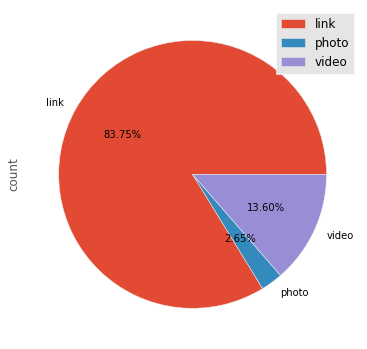

In [28]:
post_type_count_df.plot.pie('count',labels=post_type_count_df['_id'],figsize=(6, 6),autopct='%.2f%%')

84% of them are link posts, 14% are video posts, only less than 3% are photo posts. Let's see their distribution of brand_domain.

In [29]:
reducer = \
    Code("""
    function(obj, prev) {
        prev.sumpost_engaged_users = prev.sumpost_engaged_users + obj.post_engaged_users - 0;
        prev.sumpost_reactions_total = prev.sumpost_reactions_total + obj.post_reactions_total - 0;
        prev.sumpost_link_clicks = prev.sumpost_link_clicks + obj.post_link_clicks - 0;
        prev.sumpost_impressions_unique = prev.sumpost_impressions_unique + obj.post_impressions_unique - 0;
    }
    """)
post_type_sum = db.post_summary.group(key={'post_type': True}, initial={
    'sumpost_engaged_users': 0,
    'sumpost_reactions_total': 0,
    'sumpost_link_clicks': 0,
    'sumpost_impressions_unique': 0,
    }, reduce=reducer, condition={'page_name': 'Shared',
                                  'date': {'$gt': '2016-11-01',
                                  '$lt': '2016-12-01'}}, finalize=None)

# http://stackoverflow.com/questions/29039298/how-to-write-mongodb-query-in-python-for-db-collection-group
# http://api.mongodb.com/python/current/examples/aggregation.html

post_type_sum


[{u'post_type': u'link',
  u'sumpost_engaged_users': 49780393.0,
  u'sumpost_impressions_unique': 564763591.0,
  u'sumpost_link_clicks': 42330121.0,
  u'sumpost_reactions_total': 4637319.0},
 {u'post_type': u'video',
  u'sumpost_engaged_users': 15370272.0,
  u'sumpost_impressions_unique': 330032423.0,
  u'sumpost_link_clicks': 451912.0,
  u'sumpost_reactions_total': 4925135.0},
 {u'post_type': u'photo',
  u'sumpost_engaged_users': 1582457.0,
  u'sumpost_impressions_unique': 27146455.0,
  u'sumpost_link_clicks': 411413.0,
  u'sumpost_reactions_total': 486946.0}]

In [30]:
print 'Link post avg impressions_unique: ', post_type_sum[0]['sumpost_impressions_unique']/post_type_count_df['count'][2]
print 'Link post avg engaged_users: ', post_type_sum[0]['sumpost_engaged_users']/post_type_count_df['count'][2]
print 'Link post avg link_clicks: ', post_type_sum[0]['sumpost_link_clicks']/post_type_count_df['count'][2]
print 'Link post avg total reaction: ', post_type_sum[0]['sumpost_reactions_total']/post_type_count_df['count'][2]
print '---------------------------'
print 'Video post avg impressions_unique: ', post_type_sum[1]['sumpost_impressions_unique']/post_type_count_df['count'][1]
print 'Video post avg engaged_users: ', post_type_sum[1]['sumpost_engaged_users']/post_type_count_df['count'][1]
print 'Video post avg link_clicks: ', post_type_sum[1]['sumpost_link_clicks']/post_type_count_df['count'][1]
print 'Video post avg total reaction: ', post_type_sum[1]['sumpost_reactions_total']/post_type_count_df['count'][1]
print '---------------------------'
print 'Photo post avg impressions_unique: ', post_type_sum[2]['sumpost_impressions_unique']/post_type_count_df['count'][0]
print 'Photo post avg engaged_users: ', post_type_sum[2]['sumpost_engaged_users']/post_type_count_df['count'][0]
print 'Photo post avg link_clicks: ', post_type_sum[2]['sumpost_link_clicks']/post_type_count_df['count'][0]
print 'Photo post avg total reaction: ', post_type_sum[2]['sumpost_reactions_total']/post_type_count_df['count'][0]

Link post avg impressions_unique:  482703.923932
Link post avg engaged_users:  42547.3444444
Link post avg link_clicks:  36179.5905983
Link post avg total reaction:  3963.52051282
---------------------------
Video post avg impressions_unique:  1737012.75263
Video post avg engaged_users:  80896.1684211
Video post avg link_clicks:  2378.48421053
Video post avg total reaction:  25921.7631579
---------------------------
Photo post avg impressions_unique:  733687.972973
Photo post avg engaged_users:  42769.1081081
Photo post avg link_clicks:  11119.2702703
Photo post avg total reaction:  13160.7027027


In [31]:
post_type_sum_df = json_normalize(post_type_sum).sort_values('post_type')
post_type_sum_df["avgpost_engaged_users"] = post_type_sum_df["sumpost_engaged_users"] /post_type_count_df['count']
# post_type_sum_df["avgpost_impressions_unique"] = post_type_sum_df["sumpost_impressions_unique"] /post_type_count_df['count'][2]
post_type_sum_df

,post_type,sumpost_engaged_users,sumpost_impressions_unique,sumpost_link_clicks,sumpost_reactions_total,avgpost_engaged_users
0,link,49780393.000,564763591.000,42330121.000,4637319.000,1345416.027
2,photo,1582457.000,27146455.000,411413.000,486946.000,1352.527
1,video,15370272.000,330032423.000,451912.000,4925135.000,80896.168


In [32]:
post_type_count_df['count']

2    1170
0      37
1     190
Name: count, dtype: int64

In [33]:
post_type_sum_df["sumpost_engaged_users"]

0   49780393.000
2    1582457.000
1   15370272.000
Name: sumpost_engaged_users, dtype: float64

In [34]:
post_type_sum_df["sumpost_engaged_users"]/post_type_count_df['count']

0   1345416.027
1     80896.168
2      1352.527
dtype: float64

In [35]:
reducer = \
    Code("""
    function(obj, prev) {
        if (true != null) if (true instanceof Array) prev.countstar += true.length;
        else prev.countstar++;
        prev.sumpost_likes = prev.sumpost_likes + obj.post_likes - 0;
        prev.sumpost_comments = prev.sumpost_comments + obj.post_comments - 0;
        prev.sumpost_shares = prev.sumpost_shares + obj.post_shares - 0;
        prev.sumpost_reactions_total = prev.sumpost_reactions_total + obj.post_reactions_total - 0;
        prev.sumpost_impressions_unique = prev.sumpost_impressions_unique + obj.post_impressions_unique - 0;
        prev.sumpost_impressions = prev.sumpost_impressions + obj.post_impressions - 0;
        prev.sumpost_impressions_fan = prev.sumpost_impressions_fan + obj.post_impressions_fan - 0;
        prev.sumpost_impressions_fan_unique = prev.sumpost_impressions_fan_unique + obj.post_impressions_fan_unique - 0;
        prev.sumpost_link_clicks = prev.sumpost_link_clicks + obj.post_link_clicks - 0;
        prev.sumpost_link_clicks_unique = prev.sumpost_link_clicks_unique + obj.post_link_clicks_unique - 0;
        prev.sumpost_engaged_users = prev.sumpost_engaged_users + obj.post_engaged_users - 0;
        prev.sumreached_size_ratio = prev.sumreached_size_ratio + obj.reached_size_ratio - 0;
        prev.sumreached_size_ratio_fan = prev.sumreached_size_ratio_fan + obj.reached_size_ratio_fan - 0;
        prev.sumclick_size_ratio = prev.sumclick_size_ratio + obj.click_size_ratio - 0;
        prev.sumclicks_to_impressions = prev.sumclicks_to_impressions + obj.clicks_to_impressions - 0;
        prev.sumlink_clicks_to_impressions = prev.sumlink_clicks_to_impressions + obj.link_clicks_to_impressions - 0;
    }
    """)

post_summary_sum_by_post_type = db.post_summary.group(key={'post_type': True},initial={
    'countstar': 0,
    'sumpost_engaged_users': 0,
    'sumpost_reactions_total': 0,
    'sumpost_link_clicks': 0,
    'sumpost_impressions_unique': 0,
    'sumpost_likes': 0,
    'sumpost_comments': 0,
    'sumpost_shares': 0,
    'sumpost_impressions': 0,
    'sumpost_impressions_fan': 0,
    'sumpost_impressions_fan_unique': 0,
    'sumpost_link_clicks_unique': 0,
    'sumreached_size_ratio': 0,
    'sumreached_size_ratio_fan': 0,
    'sumclick_size_ratio': 0,
    'sumclicks_to_impressions': 0,
    'sumlink_clicks_to_impressions': 0,
    }, reduce=reducer, condition={'page_name': 'Shared',
                                  'date': {'$gt': '2016-11-01',
                                  '$lt': '2016-12-01'}}, finalize=None)

post_summary_sum_by_post_type

[{u'countstar': 1170.0,
  u'post_type': u'link',
  u'sumclick_size_ratio': 566.8649632054189,
  u'sumclicks_to_impressions': 11225.440307281142,
  u'sumlink_clicks_to_impressions': 8389.772932470933,
  u'sumpost_comments': 579803.0,
  u'sumpost_engaged_users': 49780393.0,
  u'sumpost_impressions': 849571127.0,
  u'sumpost_impressions_fan': 717000749.0,
  u'sumpost_impressions_fan_unique': 476650945.0,
  u'sumpost_impressions_unique': 564763591.0,
  u'sumpost_likes': 3365293.0,
  u'sumpost_link_clicks': 42330121.0,
  u'sumpost_link_clicks_unique': 38877495.0,
  u'sumpost_reactions_total': 4637319.0,
  u'sumpost_shares': 1371627.0,
  u'sumreached_size_ratio': 7561.743167656579,
  u'sumreached_size_ratio_fan': 6381.88820867486},
 {u'countstar': 190.0,
  u'post_type': u'video',
  u'sumclick_size_ratio': 6.058147349549761,
  u'sumclicks_to_impressions': 539.7611145544706,
  u'sumlink_clicks_to_impressions': 68.00328593909231,
  u'sumpost_comments': 509057.0,
  u'sumpost_engaged_users': 1537

In [36]:
pd.DataFrame(post_summary_sum_by_post_type).transpose()

,0,1,2
countstar,1170.000,190.000,37.000
post_type,link,video,photo
sumclick_size_ratio,566.865,6.058,5.485
sumclicks_to_impressions,11225.440,539.761,270.646
sumlink_clicks_to_impressions,8389.773,68.003,75.043
sumpost_comments,579803.000,509057.000,136198.000
sumpost_engaged_users,49780393.000,15370272.000,1582457.000
sumpost_impressions,849571127.000,534209052.000,46670670.000
sumpost_impressions_fan,717000749.000,204376150.000,24005821.000
sumpost_impressions_fan_unique,476650945.000,132773149.000,13754932.000


In [37]:
post_by_brand = [
    {
        "brand_domain" : "Shareably",
        "countstar" : 69.0
    },
    {
        "brand_domain" : "not defined",
        "countstar" : 376.0
    },
    {
        "brand_domain" : "Rndr",
        "countstar" : 160.0
    },
    {
        "brand_domain" : "Little Things",
        "countstar" : 187.0
    },
    {
        "brand_domain" : "Trancos",
        "countstar" : 65.0
    },
    {
        "brand_domain" : "Random Stuff",
        "countstar" : 228.0
    },
    {
        "brand_domain" : "Inspire More",
        "countstar" : 41.0
    },
    {
        "brand_domain" : "HeroViral",
        "countstar" : 92.0
    },
    {
        "brand_domain" : "PawMyGosh",
        "countstar" : 12.0
    },
    {
        "brand_domain" : "BoredomTherapy",
        "countstar" : 29.0
    },
    {
        "brand_domain" : "American Overlook",
        "countstar" : 123.0
    },
    {
        "brand_domain" : "Bricor Media",
        "countstar" : 5.0
    },
    {
        "brand_domain" : "GoFansGo",
        "countstar" : 3.0
    },
    {
        "brand_domain" : "Tickld",
        "countstar" : 1.0
    },
    {
        "brand_domain" : "Unsure Clients",
        "countstar" : 1.0
    },
    {
        "brand_domain" : "SF Globe",
        "countstar" : 4.0
    },
    {
        "brand_domain" : "TwentyTwoWords",
        "countstar" : 1.0
    }
]

In [38]:
post_by_brand_df = pd.DataFrame(post_by_brand).sort_values('countstar',ascending=False)
post_by_brand_df 

,brand_domain,countstar
1,not defined,376.000
5,Random Stuff,228.000
3,Little Things,187.000
2,Rndr,160.000
10,American Overlook,123.000
7,HeroViral,92.000
0,Shareably,69.000
4,Trancos,65.000
6,Inspire More,41.000
9,BoredomTherapy,29.000
